## Further Exploration with the Phishing dataset
Our team is continuing our look into the phishing dataset. Can other models improve over our initial results?
Dataset source [Phishing Dataset](https://github.com/GregaVrbancic/Phishing-Dataset)

In [11]:
import matplotlib.pyplot as plt
from mlxtend.classifier import StackingClassifier
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.naive_bayes import GaussianNB
from sklearn.dummy import DummyClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc, roc_auc_score


# Load the large dataset
df = pd.read_csv('phishing-full.csv')

# Define the features and target feature. target feature is in last column
features = df.columns[:-1]
X = df[features]
y = df['phishing']

# standardize the feature values
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=88)


# Baseline Performance w/Dummy Classifier w/no PCA
Using a stratified dummy classifier to get some very baseline 'dummy' predictions to use as a basis for model comparison

In [4]:
# reusable function to get metrics out easily
def get_metrics(test_data, predictions):
    accuracy = accuracy_score(test_data, predictions)
    precision = precision_score(test_data, predictions)
    recall = recall_score(test_data, predictions)
    f1 = f1_score(test_data, predictions)
    return accuracy, precision, recall, f1

# instantiate a DummyClassifier
dummy = DummyClassifier(strategy='stratified')

# trainng
dummy.fit(X_train, y_train)

# make predictions
dummy_predictions = dummy.predict(X_test)

# get metrics
dummy_accuracy, dummy_precision, dummy_recall, dummy_f1 = get_metrics(y_test, dummy_predictions)

# Put data in a dataframe for ease of displaying
metrics_df = pd.DataFrame({
    'Value': [dummy_accuracy, dummy_recall, dummy_precision, dummy_f1],
    'Metric': ['Accuracy', 'Recall', 'Precision', 'f1']
})

print(metrics_df)


      Value     Metric
0  0.541850   Accuracy
1  0.334811     Recall
2  0.333661  Precision
3  0.334235         f1


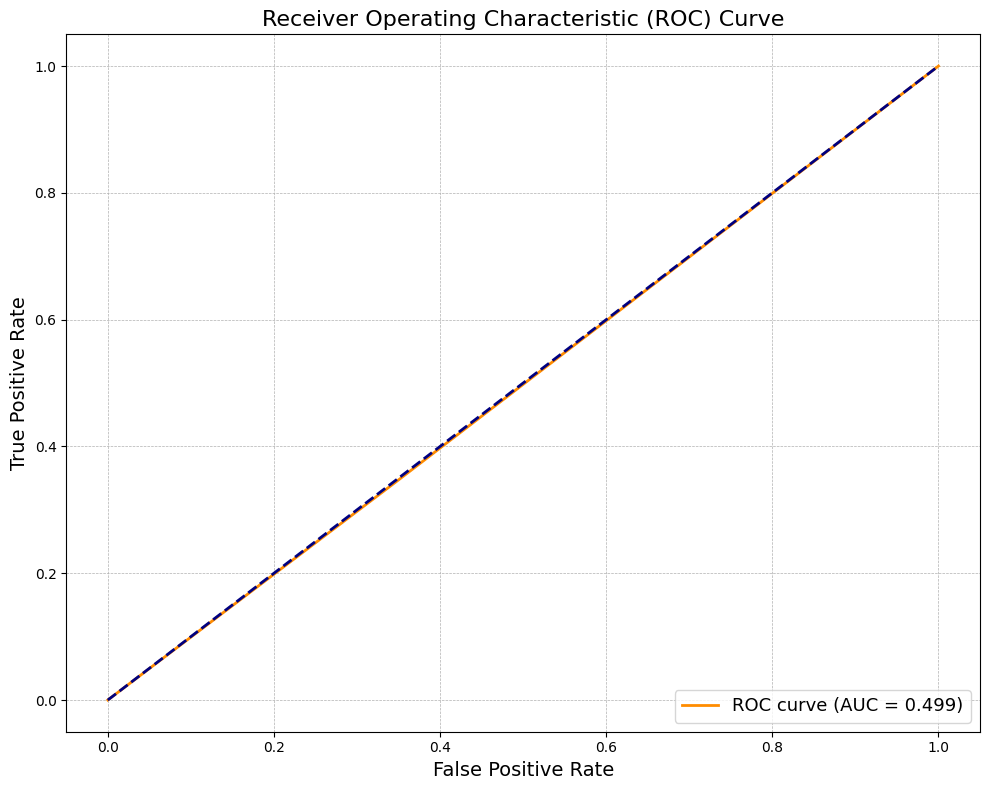

In [24]:

y_probabilities = dummy.predict_proba(X_test_pca)[:, 1]

# Calculate ROC curve
fpr, tpr, _ = roc_curve(y_test, y_probabilities)

# Calculate AUC
auc = roc_auc_score(y_test, y_probabilities)


plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {auc:.3f})')

# Highlighting the 0.5 diagonal
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

# Adding grid, title, labels, and legend
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=16)
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.legend(loc='lower right', fontsize=13)

plt.tight_layout()
plt.show()

# Applying PCA

In [5]:
# instantiate a new PCA instance and run fit_transform so we can get an understanding of components
pca = PCA()
X_pca = pca.fit_transform(X)

cumulative_variance_explained = np.cumsum(pca.explained_variance_ratio_)

# get eigenvalues
eigenvalues = pca.explained_variance_

# find the number of components with eigenvalues > 1
n_components = len(eigenvalues[eigenvalues > 1])

print(f'Components with eigenvalues > 1: {n_components}')

# create a new PCA instance using top 21 components
pca = PCA(n_components=21)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

Components with eigenvalues > 1: 21


# Base Model 1 - Random Forest
Worked on a GridSearch for RandomForest to try and identify ideal hyper-parameter tunings. Interestingly, the baseline RandomForestClassifier with default args seems to slightly out-perform a manually tuned instance.

In [38]:
# GridSearchCV

rf = RandomForestClassifier(random_state=88)

param_grid = { 
    'n_estimators': [100, 200],
    'max_features': ['sqrt', 'log2'],
    'max_depth' : [4, 6, 8, 16],
    'criterion' :['gini']
}

CV_rf = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5)
CV_rf.fit(X_train_pca, y_train)

print("Best Parameters: ", CV_rf.best_params_)
print("Best Score: ", CV_rf.best_score_)

# 21m 49s to run
# Best Parameters:  {'criterion': 'gini', 'max_depth': 16, 'max_features': 'sqrt', 'n_estimators': 200}
# Best Score:  0.9582046850015742

Best Parameters:  {'criterion': 'gini', 'max_depth': 16, 'max_features': 'sqrt', 'n_estimators': 200}
Best Score:  0.9582046850015742


In [23]:
# create a random forest using the hypertuned params
rf_model_tuned = RandomForestClassifier(n_estimators=200, max_depth=16, criterion='gini', max_features='sqrt', random_state=88, n_jobs=-1)

rf_model_tuned.fit(X_train_pca, y_train)

# predict and evaluate
rf_predictions_tuned = rf_model_tuned.predict(X_test_pca)

rf_accuracy_tuned, rf_precision_tuned, rf_recall_tuned, rf_f1_tuned = get_metrics(y_test, rf_predictions_tuned)

# put data in a dataframe for ease of displaying
metrics_df = pd.DataFrame({
    'Value': [rf_accuracy_tuned, rf_recall_tuned, rf_precision_tuned, rf_f1_tuned],
    'Metric': ['Accuracy', 'Recall', 'Precision', 'f1']
})

print("\nTuned")
print(metrics_df)

rf_model = RandomForestClassifier(random_state=88, n_jobs=-1)
rf_model.fit(X_train_pca, y_train)

# predict and evaluate
rf_predictions = rf_model.predict(X_test_pca)
rf_accuracy_tuned, rf_precision_tuned, rf_recall_tuned, rf_f1_tuned = get_metrics(y_test, rf_predictions)

# put data in a dataframe for ease of displaying
metrics_df = pd.DataFrame({
    'Value': [rf_accuracy_tuned, rf_recall_tuned, rf_precision_tuned, rf_f1_tuned],
    'Metric': ['Accuracy', 'Recall', 'Precision', 'f1']
})

print("\nUntuned")
print(metrics_df)


Tuned
      Value     Metric
0  0.959222   Accuracy
1  0.944335     Recall
2  0.937408  Precision
3  0.940859         f1

Untuned
      Value     Metric
0  0.960519   Accuracy
1  0.944663     Recall
2  0.940647  Precision
3  0.942651         f1


# Base Model 2 - Naive Bayes
This model does not have many tuning parameters but we can use a grid search to try and find the ideal var_smoothing value

In [7]:

# Define the model
nb_model = GaussianNB()

# Define the parameter grid
param_grid = {
    'var_smoothing': np.logspace(0,-9, num=100)
}

# Create a GridSearchCV object
grid_search = GridSearchCV(nb_model, param_grid, cv=5)

# Fit the GridSearchCV object to the data
grid_search.fit(X_train_pca, y_train)

# Print the best parameters and the best score
print("Best parameters: ", grid_search.best_params_)
print("Best score: ", grid_search.best_score_)

Best parameters:  {'var_smoothing': 0.005336699231206307}
Best score:  0.7423607117009994


In [8]:
# Set up the model
nb_model = GaussianNB(var_smoothing=0.005336699231206307)
nb_model.fit(X_train_pca, y_train)

# Make predictions and evaluate performance
nb_predictions = nb_model.predict(X_test_pca)

nb_accuracy_tuned, nb_precision_tuned, nb_recall_tuned, nb_f1_tuned = get_metrics(y_test, nb_predictions)

# put data in a dataframe for ease of displaying
metrics_df = pd.DataFrame({
    'Value': [nb_accuracy_tuned, nb_recall_tuned, nb_precision_tuned, nb_f1_tuned],
    'Metric': ['Accuracy', 'Recall', 'Precision', 'f1']
})

print(metrics_df)

      Value     Metric
0  0.742640   Accuracy
1  0.324138     Recall
2  0.815366  Precision
3  0.463870         f1


# Base Model 3 - SVM

In [21]:
svm = SVC(probability=True)

param_grid = {
    'C': [0.1, 1, 10, 100], 
    'gamma': [1, 0.1, 0.01, 0.001],
    'kernel': ['rbf', 'poly', 'sigmoid']
} 

CV_svm = GridSearchCV(estimator=svm, param_grid=param_grid, cv=5, verbose=4, n_jobs=-1)
CV_svm.fit(X_train_pca, y_train)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


In [10]:
svm_model = SVC(probability=True)

# Train the model using the training sets
svm_model.fit(X_train_pca, y_train)

# predict and evaluate
svm_predictions = svm_model.predict(X_test_pca)

svm_accuracy_tuned, svm_precision_tuned, svm_recall_tuned, svm_f1_tuned = get_metrics(y_test, svm_predictions)

# put data in a dataframe for ease of displaying
metrics_df = pd.DataFrame({
    'Value': [svm_accuracy_tuned, svm_recall_tuned, svm_precision_tuned, svm_f1_tuned],
    'Metric': ['Accuracy', 'Recall', 'Precision', 'f1']
})

print(metrics_df)


Naive Bayes w/PCA - Accuracy: 0.9323181049069373, Recall: 0.9082101806239737


# Set up Meta Model

In [17]:
# Define the meta-classifier type
lr_meta = LogisticRegression()

# Set up the StackingClassifier
stacked_model = StackingClassifier(classifiers=[rf_model, nb_model, svm_model], meta_classifier=lr_meta, use_probas=False, use_features_in_secondary=True, average_probas=True)

stacked_model.fit(X_train_pca, y_train)

# Make predictions and evaluate performance
stacked_predictions = stacked_model.predict(X_test_pca)

stack_accuracy_tuned, stack_precision_tuned, stack_recall_tuned, stack_f1_tuned = get_metrics(y_test, stacked_predictions)

# put data in a dataframe for ease of displaying
metrics_df = pd.DataFrame({
    'Value': [stack_accuracy_tuned, stack_recall_tuned, stack_precision_tuned, stack_f1_tuned],
    'Metric': ['Accuracy', 'Recall', 'Precision', 'f1']
})

print(metrics_df)

# Trains in about 6 minutes
# Stacked Model - Accuracy: 0.9605188945290468, Recall: 0.9446633825944171

      Value     Metric
0  0.960519   Accuracy
1  0.944663     Recall
2  0.940647  Precision
3  0.942651         f1


In [17]:



from sklearn.model_selection import GridSearchCV

# Setting up the parameter grid
param_grid = {
    'use_probas': [True, False],
    'average_probas': [True, False],
    'use_features_in_secondary': [True, False]
}

# Instantiating the grid search
grid = GridSearchCV(estimator=stacked_model, param_grid=param_grid, cv=5, n_jobs=-1)


# Define the meta-model
lr_meta = LogisticRegression()

# Set up the StackingClassifier
stacked_model = StackingClassifier(classifiers=[rf_model, nb_model, svm_model], meta_classifier=lr_meta, use_probas=True)


# Instantiating the grid search
grid = GridSearchCV(estimator=stacked_model, param_grid=param_grid, cv=5, n_jobs=-1)

# Fitting the data to the grid search
grid.fit(X_train_pca, y_train)

# Printing the best parameters and the best score
print("Best Parameters: ", grid.best_params_)
print("Best Score: ", grid.best_score_)

Best Parameters:  {'average_probas': True, 'use_features_in_secondary': True, 'use_probas': False}
Best Score:  0.9597840127311763


## Viewing ROC AUC for Stacked Model

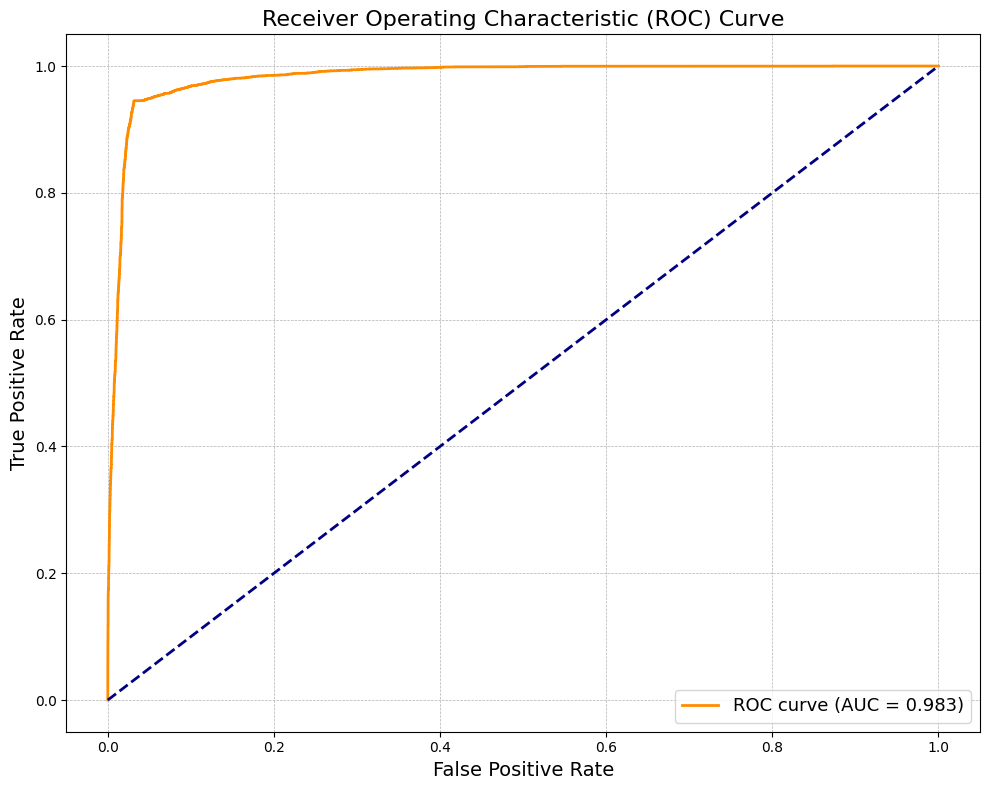

In [22]:

y_probabilities = stacked_model.predict_proba(X_test_pca)[:, 1]

# Calculate ROC curve
fpr, tpr, _ = roc_curve(y_test, y_probabilities)

# Calculate AUC
auc = roc_auc_score(y_test, y_probabilities)


plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {auc:.3f})')

# Highlighting the 0.5 diagonal
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

# Adding grid, title, labels, and legend
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=16)
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.legend(loc='lower right', fontsize=13)

plt.tight_layout()
plt.show()
